# ACIT4610 Problem Statement 2
This assignment focuses on optimizing a financial portfolio with the single objective of
maximizing expected return. You will implement and compare different versions of
Evolutionary Programming (EP) and Evolutionary Strategies (ES), including the (μ + λ) and
(μ, λ) strategies, to determine which approach yields the best portfolio allocation.

In [1]:
""" Setup the environment for the notebook """
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

""" Importlib is used to reload the module after changes.
    This is useful when developing the module and testing it in the notebook.
    The reload is done by running the cell again.

    REMEMBER TO ADD THE MODULE BELOW FOR RELOADING.
"""
import importlib

import utils.finance.ticker_loader
importlib.reload(utils.finance.ticker_loader) # Sync changes in the module
from utils.finance.ticker_loader import TickerLoader


import utils.finance.finance_manager
importlib.reload(utils.finance.finance_manager) # Sync changes in the module
from utils.finance.finance_manager import StockCalculator

import utils.plots.stocks
importlib.reload(utils.plots.stocks) # Sync changes in the module
from utils.plots.stocks import StockPlotter

DATA_LOCATION = os.path.join(os.getcwd(), 'data/raw')


## Data Preprocessing Section

1. Download the data
2. Calculate Monthly Returns
3. Covariance Matrix

In [2]:
""" Data Requirements:
Data Source:    Yahoo Finance
Data Type:      Historical Daily Stock Prices
Data Period:    01/01/2018 - 12/31/2022
Data Columns:   Date, Open, High, Low, Close, Volume (Can be more).
Description:    Need to have 20 different stocks to analyze and
    compute monthly returns.
"""

DATA_PERIOD = {
    'start': datetime.datetime(2018, 1, 1),
    'end': datetime.datetime(2022, 12, 31),
    'interval': '1d',
}

STOCK_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NOD.OL', 'NVDA', 'TSLA', 'F', 'T', 'UAA', 'PFE', 'SNAP', 'TEL.OL', 'MPCC.OL', 'AKAST.OL', 'KOG.OL', 'BA', 'U', 'ADBE', 'ORCL', 'NTDOY', 'PCG', 'KHC', 'ETA.F', 'SONY']

## Processing[1] - Download Tickers.
*Downloads from Yahoo if there's any new tickers; else loads from 'data/raw/'*

In [3]:
ticker_data = TickerLoader.load(DATA_LOCATION, STOCK_TICKERS, **DATA_PERIOD)
ticker_data.describe()

Fetching data for ETA.F...


Fetching data for SONY...


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,32041.000000,32041.000000,32041.000000,32041.000000,3.204100e+04,32041.000000,32041.000000
mean,73.686935,74.698437,72.619549,73.671647,4.474966e+07,0.004921,0.001978
std,103.408285,104.754136,101.935426,103.371584,1.075173e+08,0.119320,0.167016
min,0.051421,0.052169,0.044129,0.047869,0.000000e+00,0.000000,0.000000
25%,10.811157,10.931190,10.671595,10.800739,1.469700e+06,0.000000,0.000000
50%,25.264165,25.636085,24.869525,25.287161,9.992500e+06,0.000000,0.000000
75%,95.019010,96.108586,93.638000,94.903992,3.871216e+07,0.000000,0.000000
max,696.280029,699.539978,678.909973,688.369995,2.511528e+09,10.000000,20.000000


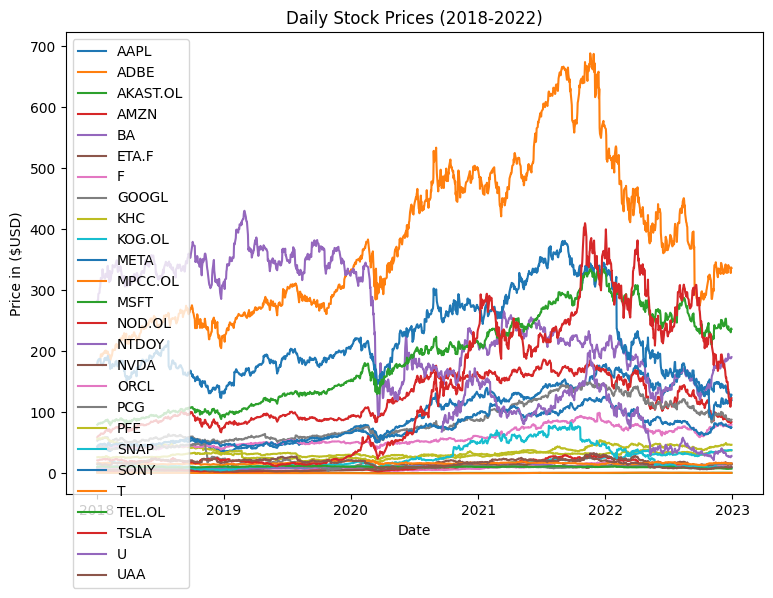

In [4]:
StockPlotter.stock_history(ticker_data, title='Daily Stock Prices (2018-2022)', ylabel='Price in ($USD)', column='Close')

In [5]:
ticker_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2018-01-02,40.074355,40.578346,39.862394,40.568924,102223600,0.0,0.0,AAPL
2018-01-03,40.632513,41.108244,40.498274,40.561859,118071600,0.0,0.0,AAPL
2018-01-04,40.634874,40.853900,40.526541,40.750275,89738400,0.0,0.0,AAPL
2018-01-05,40.846823,41.301356,40.754975,41.214218,94640000,0.0,0.0,AAPL
2018-01-08,41.061150,41.357891,40.962232,41.061150,82271200,0.0,0.0,AAPL


## Processing [2] - Monthly Returns
*Calculating the monthly returns for all tickers into one dataframe*

In [6]:
monthly_returns_df = StockCalculator.monthly_returns(ticker_data)
monthly_returns_df.describe()

,Date,Close,Returns_pct,Returns_val
count,1502,1502.000000,1502.000000,1502.000000
mean,2020-07-01 06:30:30.508474624,120.411458,0.014906,0.629518
min,2018-02-01 00:00:00,2.738979,-0.326342,-101.923141
25%,2019-04-01 00:00:00,56.163678,-0.052763,-4.589812
50%,2020-07-01 00:00:00,108.323277,0.014812,0.634988
75%,2021-10-01 00:00:00,166.189621,0.073747,6.074635
max,2022-12-01 00:00:00,378.241180,0.343770,48.451935
std,NaN,84.176267,0.098930,12.950573


In [7]:
monthly_returns_df.head()

,Date,Ticker,Close,Returns_pct,Returns_val
0,2018-02-01,AAPL,42.120049,0.068185,2.688637
1,2018-03-01,AAPL,39.674957,-0.058051,-2.445091
2,2018-04-01,AAPL,39.079037,-0.015020,-0.595921
3,2018-05-01,AAPL,44.359558,0.135124,5.280521
4,2018-06-01,AAPL,43.941772,-0.009418,-0.417786


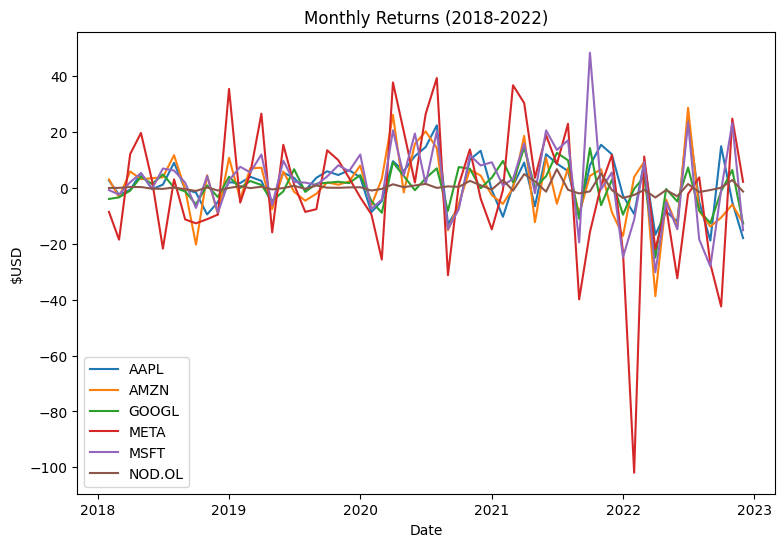

In [10]:
StockPlotter.stock_history(monthly_returns_df, title='Monthly Returns (2018-2022)', ylabel='$USD', column='Returns_val')